# Problem formulation

The problem we focused on is predicting the global temperature anomaly based on concentration of gases in the atmosphere. Data is collected from year 2001 to 2022. 
<br> <br> The result of our research can show directly how the global warming is going to change in the future years. This information can be useful for preparing society for the impact of temperature changes. It can also show how our population influence global weather changes because of gases emission.<br> <br>
Data used in our project come from two different sources. Data about global temperature anomaly comes from NASA Global Climate Change https://climate.nasa.gov/vital-signs/global-temperature/ and the gases concentration comes from Global Monitoring Laboratory https://gml.noaa.gov/. The first one contains yearly temperature anomaly around the globe. Original data was from years 1880-2023. The second data set has information about three gases concentration in the atmosphere. It not only has yearly data but also monthly.
<br> <br>
Before starting the project we created the dag graph that shows what data impacts global warming. 
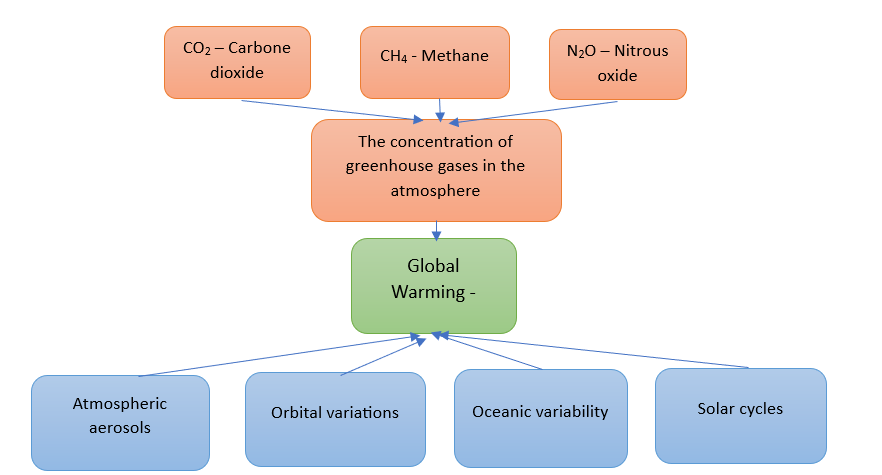. <br> The parameters we have taken into consideration are carbon dioxide(CO2), methan(CH4), nitrous oxide(N2O). Although there were more factors than only gases the ones we have chosen had the most significant impact on temperature changes. <br><br>
During the given period of time there was a globla pandemic of COVID-19. Because of that the emission of gases were much lower due to for example smaller amount of flights. This may be potentially confounding for our results. 


# Data preprocessing

As the data were clear without any NaN or Null values we didn't change much while cleaning it. We had to compute the mean value for every year when it comes to gases because the data had values for every month which we didn't need to use. These actions were taken in different file "data_preprocessing.ipnyb". 

### Imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
import arviz as az

df = pd.read_csv("root/data/data_preprocessed/data.csv", index_col=0)
df.head()

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,year,CO2,CH4,N2O,Temperature
0,2001,371.319167,1771.269167,316.364167,0.54
1,2002,373.452500,1772.731667,316.942500,0.63
2,2003,375.983333,1777.334167,317.631667,0.62
3,2004,377.698333,1776.995833,318.262500,0.53
4,2005,379.983333,1774.180000,318.920000,0.68


### Data standarization

Data was standarized using MinMax scaler. We wanted to have our parameters in the similar range and in not so big scale as they were before. The standard score of a sample x is calculated as follows in code:

In [10]:
scaler = StandardScaler()
df[['CO2', 'CH4', 'N2O']] = scaler.fit_transform(df[['CO2', 'CH4', 'N2O']])

print(df)

    year       CO2       CH4       N2O  Temperature
0   2001 -1.598865 -1.102843 -1.483935         0.54
1   2002 -1.449492 -1.068258 -1.384767         0.63
2   2003 -1.272287 -0.959418 -1.266593         0.62
3   2004 -1.152206 -0.967419 -1.158423         0.53
4   2005 -0.992214 -1.034008 -1.045679         0.68
5   2006 -0.844650 -1.015326 -0.890782         0.64
6   2007 -0.709223 -0.861555 -0.782897         0.67
7   2008 -0.582723 -0.728771 -0.602136         0.54
8   2009 -0.455931 -0.575395 -0.469245         0.66
9   2010 -0.283744 -0.448149 -0.312204         0.73
10  2011 -0.161270 -0.348670 -0.137302         0.61
11  2012 -0.006880 -0.231750  0.007021         0.65
12  2013  0.180886 -0.105253  0.159489         0.68
13  2014  0.326174  0.114358  0.355969         0.75
14  2015  0.480156  0.389186  0.541731         0.90
15  2016  0.718277  0.598510  0.674336         1.02
16  2017  0.882529  0.752518  0.810657         0.92
17  2018  1.019531  0.934489  1.010995         0.85
18  2019  1.

Text(0.5, 1.0, 'Temperature during the years')

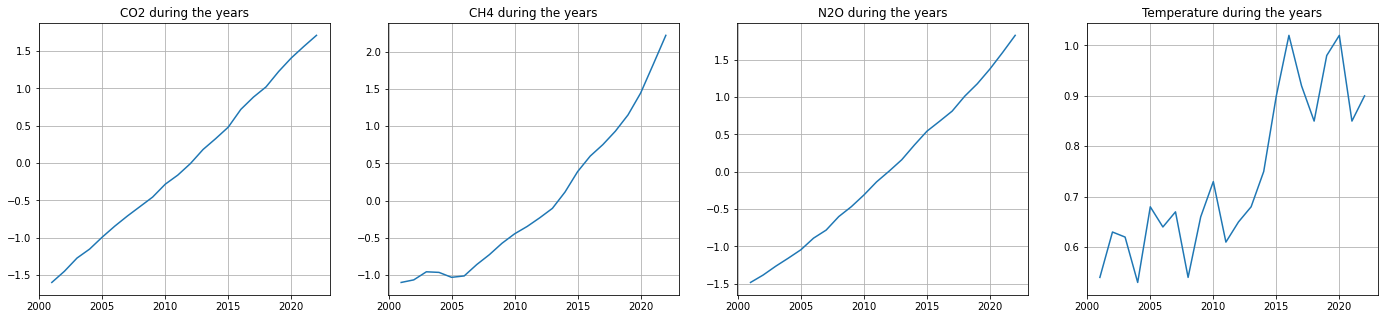

In [30]:
fig, axs = plt.subplots(1,4, figsize=(24,5))
axs[0].plot(df['year'],df['CO2'])
axs[0].grid()
axs[0].set_title("CO2 during the years")
axs[0].axis
axs[1].plot(df['year'],df['CH4'])
axs[1].grid()
axs[1].set_title("CH4 during the years")
axs[2].plot(df['year'],df['N2O'])
axs[2].grid()
axs[2].set_title("N2O during the years")
axs[3].plot(df['year'],df['Temperature'])
axs[3].grid()
axs[3].set_title("Temperature during the years")

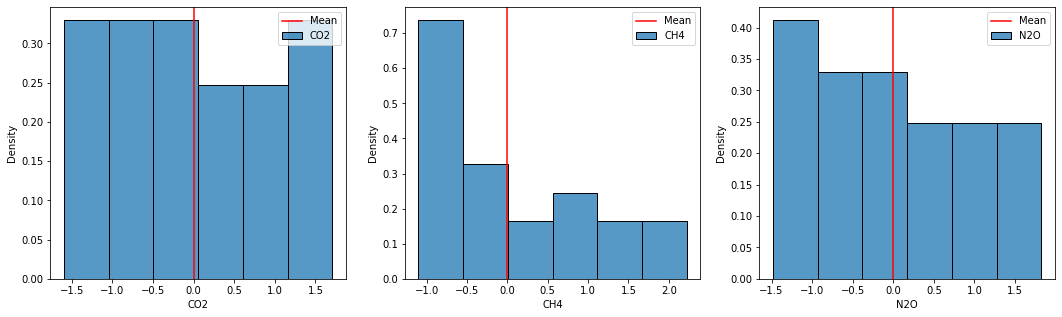

In [33]:

fig, axs = plt.subplots(1,3, figsize=(18,5))
graph = sns.histplot(data=df, x='CO2', label='CO2', ax=axs[0], stat='density')
graph.axvline(df.CO2.mean(), color='red', label='Mean')
graph.legend()

graph = sns.histplot(data=df, x='CH4', label='CH4', ax=axs[1], stat='density')
graph.axvline(df.CH4.mean(), label='Mean', color='red')
graph.legend()

graph = sns.histplot(data=df, x='N2O', label='N2O', ax=axs[2], stat='density')
graph.axvline(df.N2O.mean(), label='Mean', color='red')
graph.legend()
plt.show()

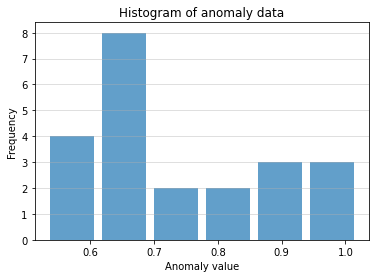

In [16]:
plt.hist(np.array(df['Temperature']), bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Anomaly value')
plt.ylabel('Frequency')
plt.title('Histogram of anomaly data')
plt.show()

From histogram above we can see that the data doesn't have strong resemblance for any of distributions. At first we thought about Gamma distribution but after some actions the results weren't satisfying so we decided to go with  Normal Distribution

_________________________________________________________

# Model 1 - Normal Distribution

Our first approach was to create model with Normal Distribution. It is characterized by its symmetric bell shaped curve. It is defined by two parameters: mean and standard deviation. It is symmetric around mean value so it represents center of distribution while the standard deviation determines the spread of the data. <br> <br> 
Below plots shows that correlation between our parameters and temperature data can be considered to be linear and that is why we have chosen this approach in the model. <br> <br> Standard Bayesian model: $outcome_{i}$ ~ Normal($\mu_{i}$, $\sigma$)
    $\mu_{i}$ = $\alpha$+ $\beta$ * $predictor_{i}$
    $\alpha$ ~ Normal(a,b)
    $\beta$ ~ Normal(c,d)
    $\sigma$ ~ Normal(f,g)

The sum of multiplications beta and predictors is added two more times to the equation for every single predictor. $\alpha$ is usually the mean value of the data and $\sigma$  parameter is standard deviation.

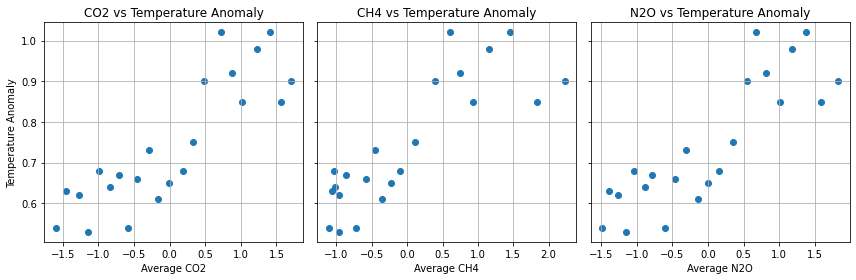

In [34]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axs[0].scatter(df['CO2'], df['Temperature'])
axs[0].set_xlabel('Average CO2')
axs[0].set_ylabel('Temperature Anomaly')
axs[0].set_title('CO2 vs Temperature Anomaly')
axs[0].grid()

axs[1].scatter(df['CH4'], df['Temperature'])
axs[1].set_xlabel('Average CH4')
axs[1].set_title('CH4 vs Temperature Anomaly')
axs[1].grid()

axs[2].scatter(df['N2O'], df['Temperature'])
axs[2].set_xlabel('Average N2O')
axs[2].set_title('N2O vs Temperature Anomaly')
axs[2].grid()

plt.tight_layout()
plt.show()

## Prior

Alpha normal distribution is based on the mean value of 'Temperature Anomaly' in the data set and sigma is based on standard deviation of the same data. Beta for every predictor and sigma is also normally distributed. The parameters for distribution of beta where chosen considering the output of this prior model. It was the most difficult challenge to  fit beta parameters properly. 

In [38]:
%%writefile root/stan_files/temp3_ppc.stan
data {
  int<lower=0> N;
  vector[N] CO2;
  vector[N] CH4;
  vector[N] N2O;
}

generated quantities {
  real alpha = normal_rng(0.7, 0.1);
  real beta_CO2 = normal_rng(0, 0.1);
  real beta_CH4 = normal_rng(0, 0.1);
  real beta_N2O = normal_rng(0, 0.1);
  real sigma = normal_rng(0.1, 0.02);
  vector[N] temperature;
  array[N] real mu;

  for (i in 1:N) {
    mu[i] = alpha + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i];
    temperature[i] = normal_rng(alpha + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i], sigma);
  }
}


Overwriting root/stan_files/temp3_ppc.stan


In [39]:
data_sim={'N':len(df), 'CO2':np.linspace(df.CO2.min(),df.CO2.max(),len(df)),'CH4':np.linspace(df.CH4.min(),df.CH4.max(),len(df)),'N2O':np.linspace(df.N2O.min(),df.N2O.max(),len(df))}
model_ppc1=CmdStanModel(stan_file='root/stan_files/temp3_ppc.stan')
R = 1000
sim=model_ppc1.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /root/stan_files/temp3_ppc.stan to exe file /root/stan_files/temp3_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp3_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [40]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta_CO2,beta_CH4,beta_N2O,sigma,temperature[1],temperature[2],temperature[3],...,mu[13],mu[14],mu[15],mu[16],mu[17],mu[18],mu[19],mu[20],mu[21],mu[22]
0,0.0,0.0,0.970817,0.077718,-0.127227,0.012759,0.072212,0.985710,1.048590,1.119710,...,0.897076,0.891171,0.885267,0.879362,0.873457,0.867552,0.861647,0.855742,0.849838,0.843933
1,0.0,0.0,0.635055,0.118083,-0.014296,-0.015998,0.112775,0.534230,0.179542,0.630123,...,0.651542,0.665357,0.679172,0.692987,0.706802,0.720617,0.734432,0.748247,0.762062,0.775877
2,0.0,0.0,0.699322,-0.000371,0.121486,0.075957,0.114794,0.588463,0.623650,0.606261,...,0.827128,0.858287,0.889446,0.920605,0.951764,0.982923,1.014080,1.045240,1.076400,1.107560
3,0.0,0.0,0.606081,0.106421,-0.002303,0.037027,0.088234,0.462742,0.446727,0.355780,...,0.650327,0.672561,0.694794,0.717028,0.739262,0.761496,0.783729,0.805963,0.828197,0.850431
4,0.0,0.0,0.577813,0.141649,-0.018822,-0.016031,0.112103,0.440043,0.511638,0.191112,...,0.597541,0.614346,0.631151,0.647956,0.664761,0.681566,0.698371,0.715175,0.731980,0.748785


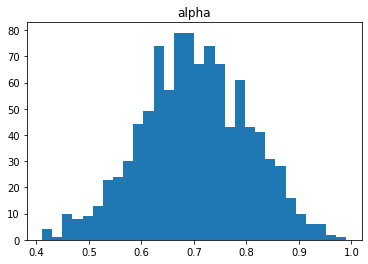

In [41]:
plt.hist(ppc_df['alpha'], bins=30)
plt.title('alpha')
plt.show()

Parameter alpha is in the right range and is wider on the center which is good.

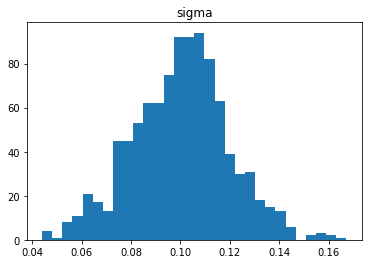

In [42]:
plt.hist(ppc_df['sigma'], bins=30)
plt.title('sigma')
plt.show()

Parameter sigma looks also okay with tha values at the meant range

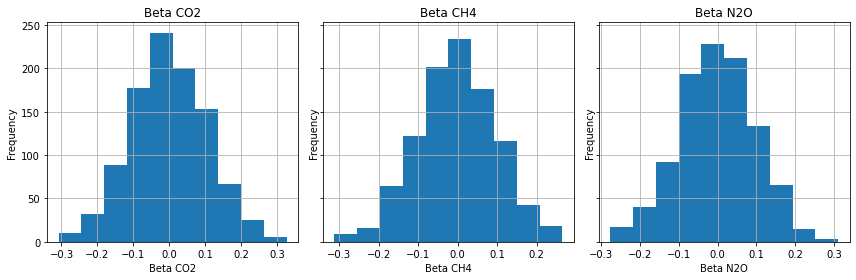

In [43]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axs[0].hist(ppc_df['beta_CO2'])
axs[0].set_xlabel('Beta CO2')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Beta CO2')
axs[0].grid()

axs[1].hist(ppc_df['beta_CH4'])
axs[1].set_xlabel('Beta CH4')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Beta CH4')
axs[1].grid()

axs[2].hist(ppc_df['beta_N2O'])
axs[2].set_xlabel('Beta N2O')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Beta N2O')
axs[2].grid()

plt.tight_layout()
plt.show()

As we put the same values for beta distribution parameters for predictors their histograms look almost the same. We wanted for all the predictors to have the same impact on our model. 

Text(80, 20, 'min')

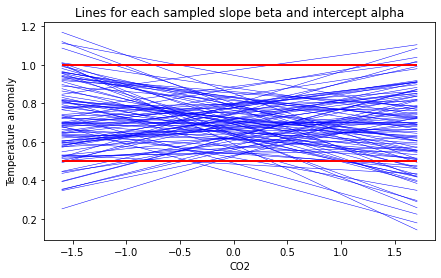

In [44]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = sim.stan_variable('beta_CO2')
alpha_humid = sim.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled slope beta and intercept alpha")
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.hlines([0.5, 1],xmin = df['CO2'].min(), xmax = df['CO2'].max(), linestyles = '-',linewidth = 2, color = 'r')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

This model fits just fine. Those lines that are under or above min and max values on the plot are acceptable because temperature anomaly can go below 0.5 (even below 0) and above 1. After fitting the data to the model everything should be between those lines perfectly. 

Lets see how the actual temperature data corresponds with the data from prior.

Text(80, 20, 'min')

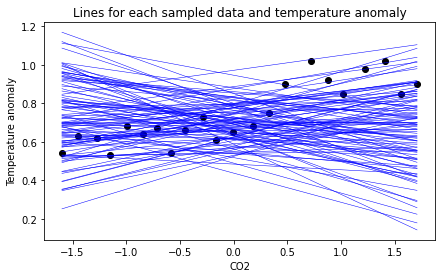

In [45]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = sim.stan_variable('beta_CO2')
alpha_humid = sim.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled data and temperature anomaly")
axes.scatter(df['CO2'], df['Temperature'], color= 'black')
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

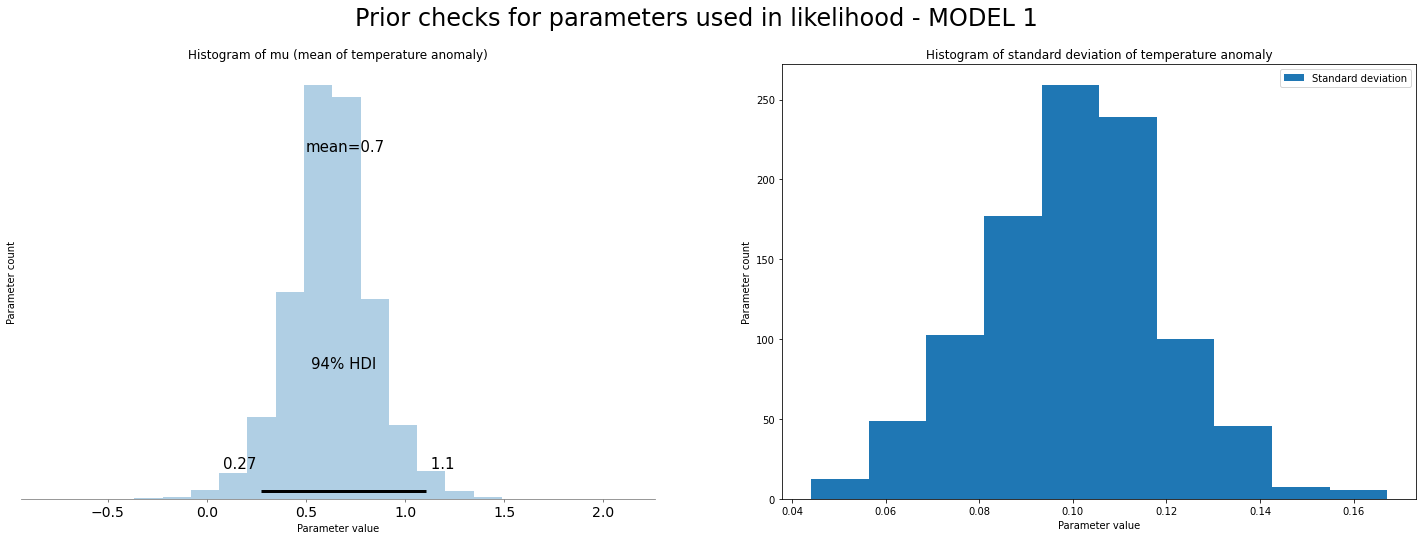

In [48]:
# plot preparation
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_ppc_mu = sim.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_ppc_mu, kind='hist', ax=ax1[0], group='prior')
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of temperature anomaly)")

# get meal_prep_coeff coeff
model1_ppc_sigma = sim.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_ppc_sigma,label="Standard deviation")
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of standard deviation of temperature anomaly")
plt.show()


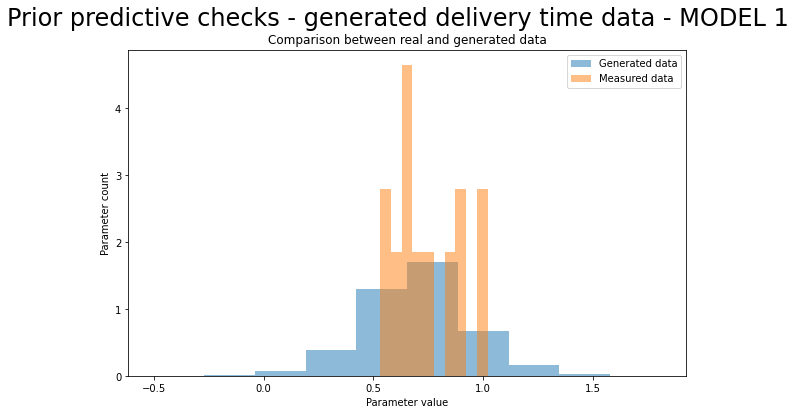

In [54]:

fig2, ax2= plt.subplots(1,1, figsize=(10,6))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=24)

# get measurements
model1_ppc_measurements = sim.stan_variable('temperature').flatten()  # flatten makes it row/column vector (one of these)

# plot measurements
ax2.hist(model1_ppc_measurements, density=True,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2.hist(df["Temperature"], density=True,  alpha=0.5, label="Measured data")
ax2.legend()
ax2.set_xlabel("Parameter value")
ax2.set_ylabel("Parameter count")
ax2.set_title("Comparison between real and generated data")
plt.show()

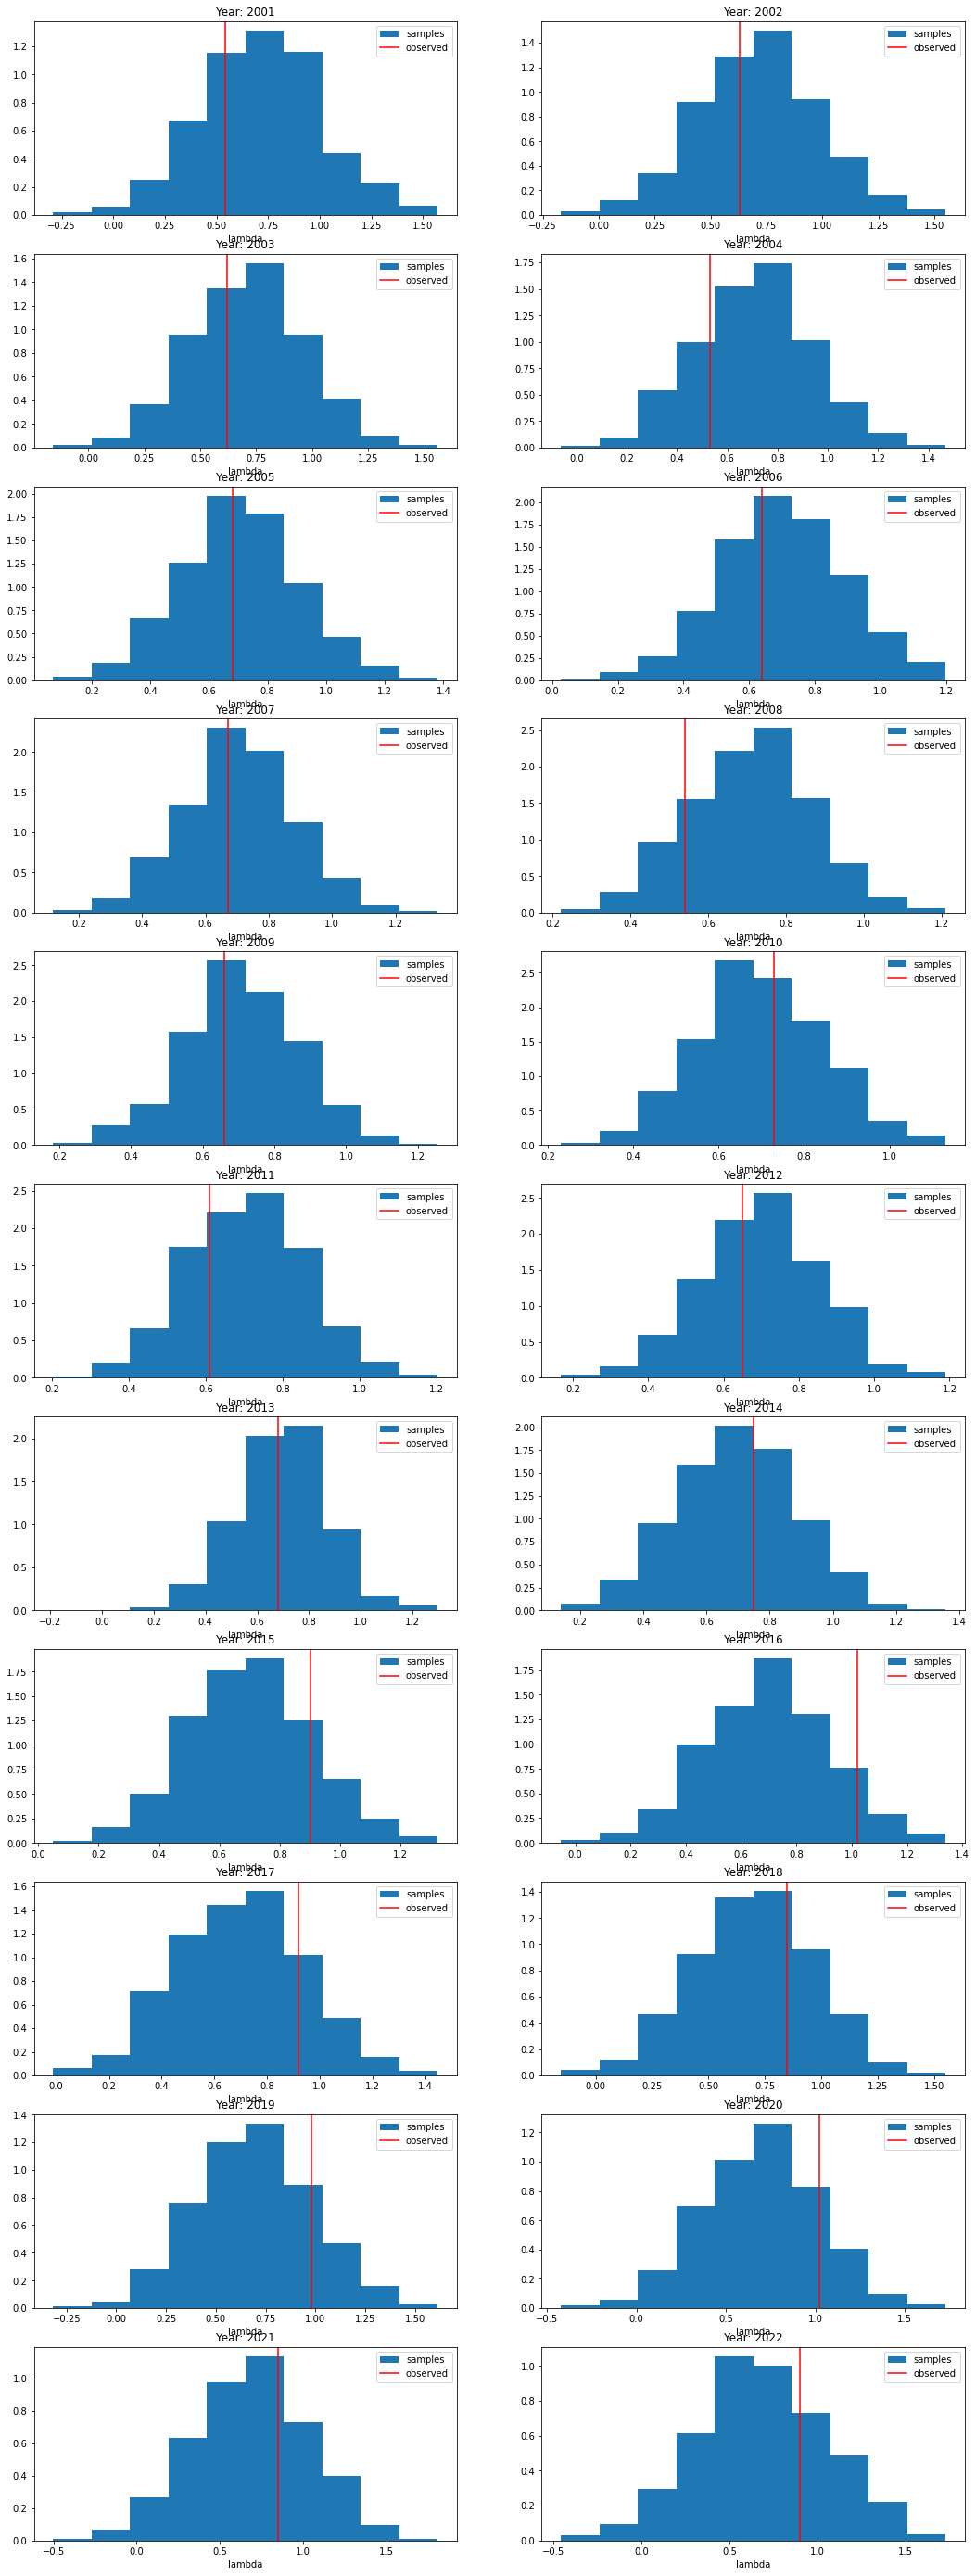

In [55]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 50))
axes = axes.flatten()
df_fit = sim.draws_pd()
sampled_lambdas = df_fit.loc[:, "temperature[1]":"temperature[22]"]
observed_lambda = df['Temperature'].values
for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'temperature[{i + 1}]'].values, density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {df["year"][i]}')
    ax.legend()

## Posterior predictive check

##### Fitting model to data

In [56]:
%%writefile root/stan_files/temp4_ppc.stan

data {
    int<lower=0> N;
    vector[N] temp;
    vector[N] CO2;
    vector[N] CH4;
    vector[N] N2O;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta_CO2;
    real<lower=0> beta_CH4;
    real<lower=0> beta_N2O;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
        mean[i] = alpha + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i];
    }
}

model {
    alpha ~ normal(0.7, 0.1);
    sigma ~ normal(0.1, 0.02);
    beta_CO2 ~ normal(0, 0.1);
    beta_CH4 ~ normal(0, 0.1);
    beta_N2O ~ normal(0, 0.1);
    for (i in 1:N) {
        temp[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] temp_;
    vector[N] log_lik;
    for (i in 1:N) {
        temp_[i] = normal_rng(mean[i], sigma);
        log_lik[i] = normal_lpdf(temp_[i]|mean[i], sigma);
    }
}


Overwriting root/stan_files/temp4_ppc.stan


In [57]:
model_1_fit=CmdStanModel(stan_file='root/stan_files/temp4_ppc.stan')
N = len(df)
data_fit = {'N': N, 'CO2': df.CO2.values[:N], 'temp': df.Temperature.values[:N], 'CH4': df.CH4.values[:N], 'N2O': df.N2O.values[:N]}
fit=model_1_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:compiling stan file /root/stan_files/temp4_ppc.stan to exe file /root/stan_files/temp4_ppc
INFO:cmdstanpy:compiled model executable: /root/stan_files/temp4_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


There were no issues with the sampling

In [58]:
df_ = fit.draws_pd()
df_.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta_CO2,...,log_lik[13],log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19],log_lik[20],log_lik[21],log_lik[22]
0,27.9625,0.985636,0.167017,5.0,31.0,0.0,-27.1543,0.742672,0.098222,0.037101,...,0.418371,1.389580,0.909479,0.610863,0.854060,1.389200,0.446135,1.284320,-0.643606,1.26768
1,30.4195,0.999059,0.167017,5.0,31.0,0.0,-27.0724,0.747539,0.082064,0.046266,...,1.489310,0.153962,1.581290,0.519966,-0.033177,1.436920,1.380760,1.513080,-3.353400,1.54954
2,31.0292,0.994093,0.167017,5.0,31.0,0.0,-29.3316,0.736152,0.099784,0.070291,...,0.176925,-0.812033,-2.591740,1.385520,1.025260,1.371490,1.347590,1.221020,1.383010,1.37259
3,29.5738,0.978468,0.167017,4.0,15.0,0.0,-28.5692,0.707534,0.084646,0.040462,...,1.460780,1.083030,1.498680,-0.623255,0.146163,1.412070,1.408160,0.949363,1.061360,1.41005
4,28.9220,0.907824,0.167017,4.0,15.0,0.0,-26.5229,0.718149,0.100418,0.032382,...,0.689437,1.013680,0.833834,1.349390,-0.252048,0.725727,1.340430,1.205930,-1.550260,1.28491


Text(80, 20, 'min')

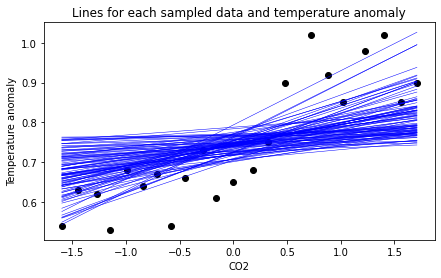

In [59]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = fit.stan_variable('beta_CO2')
alpha_humid = fit.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled data and temperature anomaly")
axes.scatter(df['CO2'], df['Temperature'], color= 'black')
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

Now the lines are more adjusted to actual data. There are less data points on the center and so there are less wide lines there. As the data is spread at the ends  so are the lines 

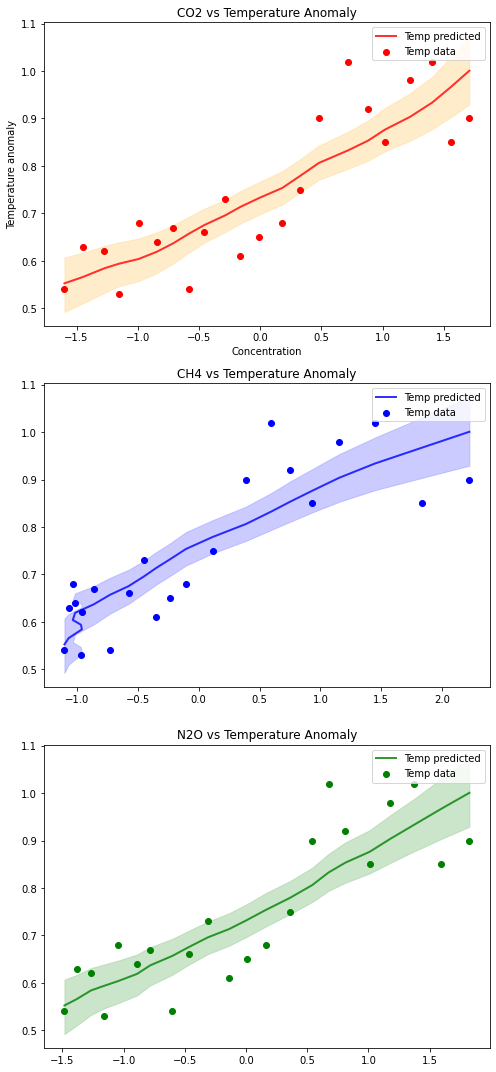

In [60]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

CO2 = np.array(df['CO2'])
CH4 = np.array(df['CH4'])
N2O = np.array(df['N2O'])
Temperature = np.array(df['Temperature'])
mu_CO2 = fit.stan_variable('mean')
mu_CH4 = fit.stan_variable('mean')
mu_N2O = fit.stan_variable('mean')


fig, ax = plt.subplots(3, 1, figsize=(7 ,15))

ax[0].fill_between(
    CO2,
    np.percentile(mu_CO2, 5, axis=0),
    np.percentile(mu_CO2, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('orange'))),
    alpha=0.5
)

ax[1].fill_between(
    CH4,
    np.percentile(mu_CH4, 5, axis=0),
    np.percentile(mu_CH4, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('blue'))),
    alpha=0.5
)

ax[2].fill_between(
    N2O,
    np.percentile(mu_N2O, 5, axis=0),
    np.percentile(mu_N2O, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('green'))),
    alpha=0.5
)

ax[0].plot(
    CO2,
    np.percentile(mu_CO2, 50, axis=0),
    color='red',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)
ax[1].plot(
    CH4,
    np.percentile(mu_CH4, 50, axis=0),
    color='blue',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)
ax[2].plot(
    N2O,
    np.percentile(mu_N2O, 50, axis=0),
    color='green',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)

ax[0].scatter(CO2, Temperature, color='red', label='Temp data')
ax[1].scatter(CH4, Temperature, color='blue', label='Temp data')
ax[2].scatter(N2O, Temperature, color='green', label='Temp data')

ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Temperature anomaly')


ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_title('CO2 vs Temperature Anomaly')
ax[1].set_title('CH4 vs Temperature Anomaly')
ax[2].set_title('N2O vs Temperature Anomaly')
plt.tight_layout()
plt.show()



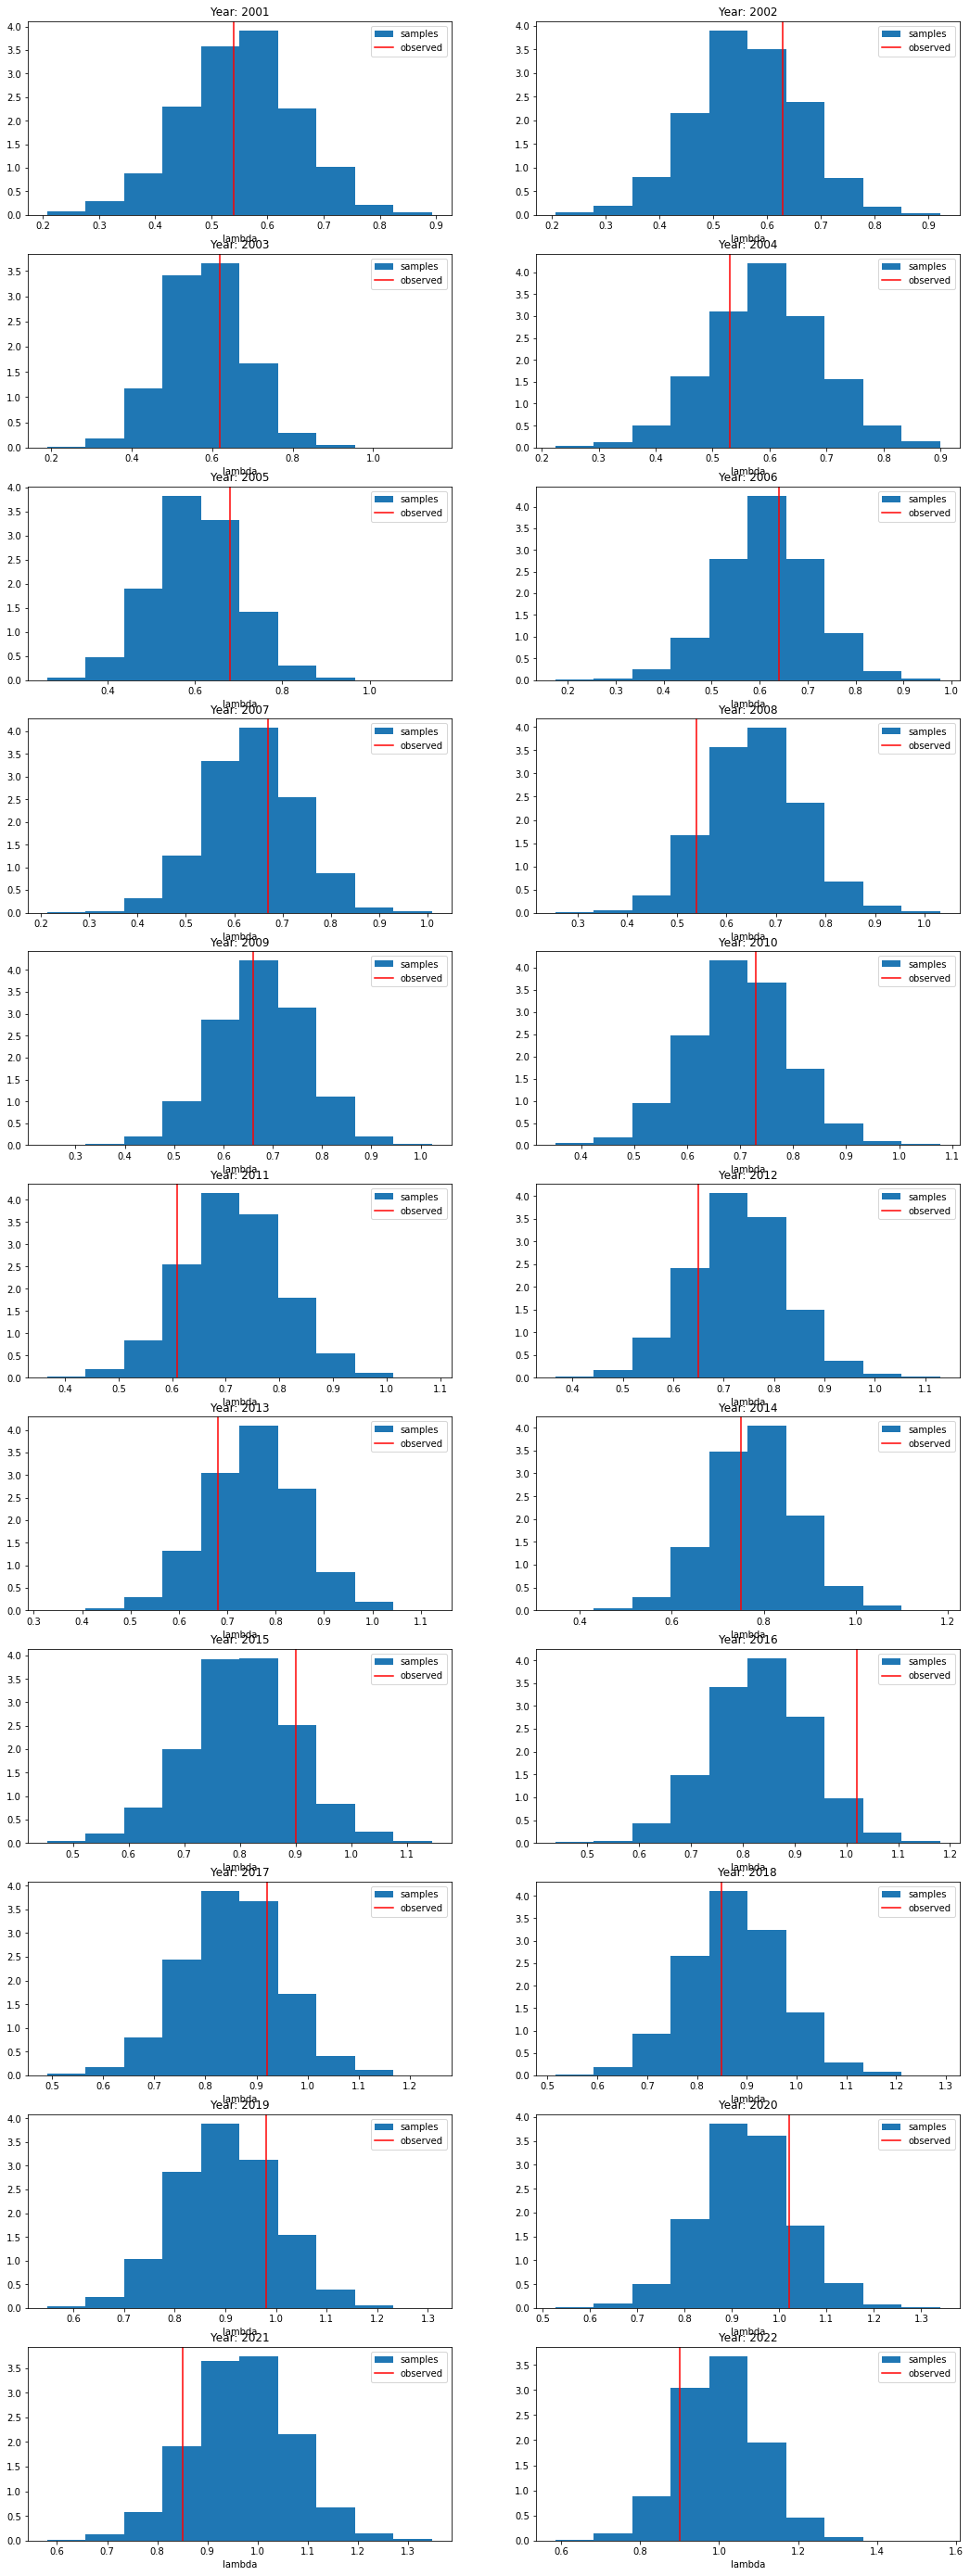

In [62]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 50))
axes = axes.flatten()
df_fit = fit.draws_pd()
sampled_lambdas = df_fit.loc[:, "temp_[1]":"temp_[22]"]
observed_lambda = df['Temperature'].values
for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'temp_[{i + 1}]'].values, density=True, label='samples')
    ax.axvline(x=observed_lambda[i], color='r', label='observed')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {df["year"][i]}')
    ax.legend()

Shown output data is consistent with the provided data of temperatures anomaly. For each gases the output mean fits great.

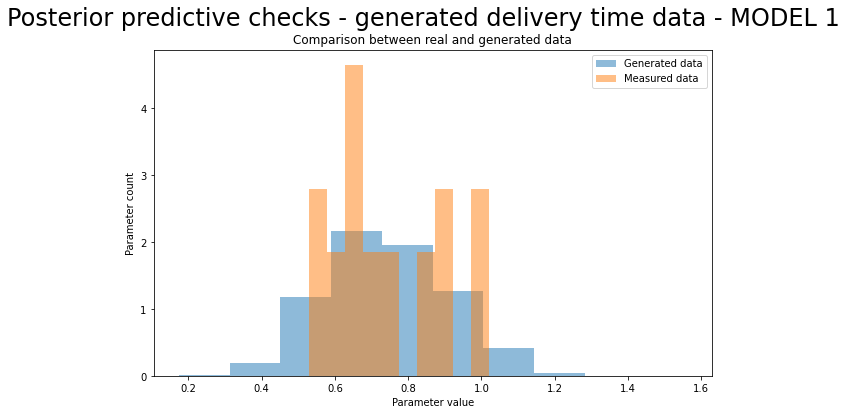

In [64]:
fig2, ax2= plt.subplots(1,1, figsize=(10,6))
fig2.suptitle("Posterior predictive checks - generated delivery time data - MODEL 1", fontsize=24)

# get measurements
model1_ppc_measurements = fit.stan_variable('temp_').flatten()  # flatten makes it row/column vector (one of these)

# plot measurements
ax2.hist(model1_ppc_measurements, density=True,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2.hist(df["Temperature"], density=True,  alpha=0.5, label="Measured data")
ax2.legend()
ax2.set_xlabel("Parameter value")
ax2.set_ylabel("Parameter count")
ax2.set_title("Comparison between real and generated data")
plt.show()

### Marginal Distribution 

0.7803419999999998


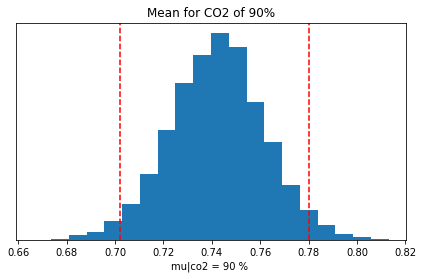

Mean: 0.74
95% confidence interval:  ['0.70', '0.78']


In [111]:
alpha_post =  fit.stan_variable('alpha')
beta_post = fit.stan_variable('beta_CO2')
mu_post = fit.stan_variable('mean')

mu90 = alpha_post+beta_post*(np.mean(df['CO2']))
mu_95p = az.hdi(mu90,.95)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu90,bins=20,density=True)
plt.axvline(mu_95p[0], linestyle = '--', color = 'r')
plt.axvline(mu_95p[1], linestyle = '--', color = 'r')
ax.set_title('Mean for CO2 of 90%')
ax.set_yticks(())
ax.set_xlabel('mu|co2 = 90 % ')
plt.show()
print('Mean: {:4.2f}'.format(np.mean(mu90)))
print('95% confidence interval: ',['{:4.2f}'.format(k) for k in az.hdi(mu90,.95)])

From above histogram we can see that on 90% propability the temperature anomaly will be in range 0.7 and 0.78. The other gases are not gonna be checked due to the similar data with CO2

# Model 2 - Student_t distribution 

Our second model approach will be to apply a Student-t distribution <br> <br> 
The Student-t distribution is similar in shape to the Gaussian but has heavier tails. It is symmetric and bell-shaped, with single peak. This model have more probability mass and allows to better represnt  data that may have outliers. <br> <br> 
The t-distribution is characterized by called degrees of freedom $\nu$ (nu) which determines the shape of the distribution. The more degrees of freedom the closer it is to the Gaussian distribution. The model have two other parameters: $\mu$ (mu) – location, $\sigma$ (sigma)- scale witch are similar to the Gaussian model. <br> <br> 
For this model we used the linear relation too. 


## Prior

Alpha, beta and sigma data were selected similarly as in the first model. The main difference is new nu parameter which we choose based on internet: https://statmodeling.stat.columbia.edu/2015/05/17/do-we-have-any-recommendations-for-priors-for-student_ts-degrees-of-freedom-parameter/

In [12]:
%%writefile /home/temp7_ppc_prior.stan
data {
  int<lower=0> N;
  vector[N] CO2;
  vector[N] CH4;
  vector[N] N2O;
}

generated quantities {
  real sigma = normal_rng(0.1,0.05);
  real nu = gamma_rng(2, 0.1);
  real alpha = normal_rng(0.7, 0.1);
  real beta_CO2 = normal_rng(0, 0.1);
  real beta_CH4 = normal_rng(0, 0.1);
  real beta_N2O = normal_rng(0, 0.1);
  vector[N] temperature;

  for (i in 1:N) {
    temperature[i] = student_t_rng(nu, alpha + beta_CO2 * CO2[i] + beta_CH4 * CH4[i] + beta_N2O * N2O[i], sigma);
  }
}


Overwriting /home/temp7_ppc_prior.stan


In [21]:
data_sim={'N':len(df), 'CO2':np.linspace(df.CO2.min(),df.CO2.max(),len(df)),'CH4':np.linspace(df.CH4.min(),df.CH4.max(),len(df)),'N2O':np.linspace(df.N2O.min(),df.N2O.max(),len(df))}

In [15]:
model_ppc7_p=CmdStanModel(stan_file='/home/temp7_ppc_prior.stan')
R = 1000
sim7=model_ppc7_p.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)
df_7_p = sim7.draws_pd()
df_7_p.head()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,sigma,nu,alpha,beta_CO2,beta_CH4,beta_N2O,temperature[1],temperature[2],...,temperature[13],temperature[14],temperature[15],temperature[16],temperature[17],temperature[18],temperature[19],temperature[20],temperature[21],temperature[22]
0,0.0,0.0,0.235409,10.8336,0.693634,-0.127227,0.012759,-0.138942,1.146710,1.216910,...,0.541558,0.803151,0.689611,0.268663,0.122831,0.573486,-0.109956,0.486857,0.529211,0.217541
1,0.0,0.0,0.122755,20.6335,0.643012,0.104238,0.116276,0.188285,0.299489,0.171137,...,0.850172,1.016260,1.171410,1.099780,0.851386,0.944927,1.277530,1.283710,1.525910,1.516970
2,0.0,0.0,0.048386,26.1987,0.650050,0.024688,-0.058932,-0.001650,0.727714,0.671177,...,0.603377,0.573427,0.637035,0.582179,0.608737,0.525994,0.634293,0.627904,0.529219,0.455498
3,0.0,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.101699,9.8558,0.743006,0.110379,-0.049400,-0.065600,0.685745,0.779902,...,0.881137,0.738824,0.655149,0.699817,0.662181,0.733661,0.765332,0.944646,0.704042,0.814588


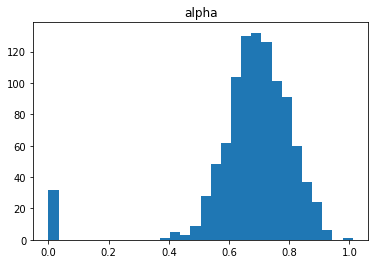

In [16]:
plt.hist(df_7_p['alpha'], bins=30)
plt.title('alpha')
plt.show()

Parameter alpha is in right range and most of the values are in the middle but some stick out.

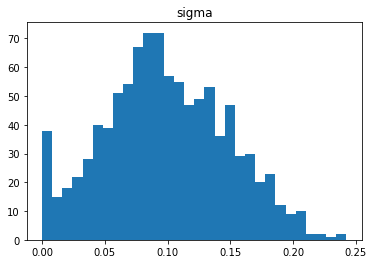

In [17]:
plt.hist(df_7_p['sigma'], bins=30)
plt.title('sigma')
plt.show()

Parameter sigma have values in the middle and this is okay

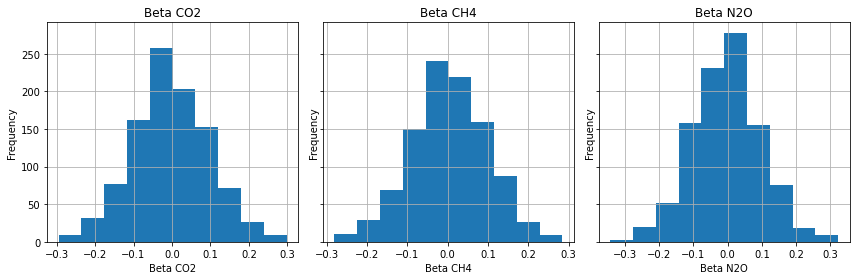

In [18]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

axs[0].hist(df_7_p['beta_CO2'])
axs[0].set_xlabel('Beta CO2')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Beta CO2')
axs[0].grid()

axs[1].hist(df_7_p['beta_CH4'])
axs[1].set_xlabel('Beta CH4')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Beta CH4')
axs[1].grid()

axs[2].hist(df_7_p['beta_N2O'])
axs[2].set_xlabel('Beta N2O')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Beta N2O')
axs[2].grid()

plt.tight_layout()
plt.show()

In this model we put the same values for beta distribution like in the first model and the historams look almost the same

Text(80, 20, 'min')

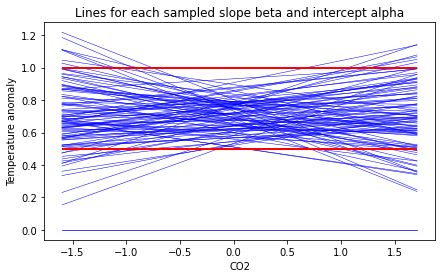

In [19]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = sim7.stan_variable('beta_CO2')
alpha_humid = sim7.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled slope beta and intercept alpha")
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.hlines([0.5, 1],xmin = df['CO2'].min(), xmax = df['CO2'].max(), linestyles = '-',linewidth = 2, color = 'r')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

Text(80, 20, 'min')

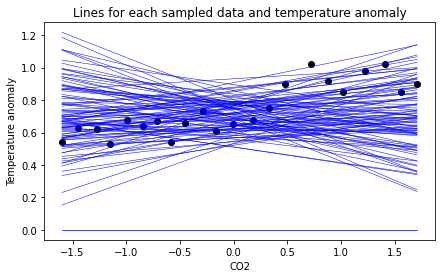

In [20]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = sim7.stan_variable('beta_CO2')
alpha_humid = sim7.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled data and temperature anomaly")
axes.scatter(df['CO2'], df['Temperature'], color= 'black')
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

In this two plots we can see that the actual temperature data correspods with data from priors and the most of samples fits.

# Prosterior predictive check

Fitting model to data

In [23]:
%%writefile /home/temp7_ppc.stan
data {
  int<lower=0> N; // number of data points
  vector[N] CO2;
  vector[N] CH4;
  vector[N] N2O;
  vector[N] temp;
}
parameters {
  real<lower=0> alpha;
  real<lower=0> beta_CO2;
  real<lower=0> beta_CH4;
  real<lower=0> beta_N2O;
  real<lower=0> sigma;
  real<lower=1, upper=80> nu;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta_CO2 * CO2 + beta_CH4 * CH4 + beta_N2O * N2O;
}
model {
  nu ~ gamma(2, 0.1); // found this online: Juarez and Steel(2010)
  temp ~ student_t(nu, mu, sigma);
  alpha ~ normal(0.7, 0.1);
  beta_CO2 ~ normal(0, 0.1);
  beta_CH4 ~ normal(0, 0.1);
  beta_N2O ~ normal(0, 0.1);
  sigma ~ normal(0.1,0.05);

}
generated quantities {
    vector[N] temp_i;
    vector[N] log_lik;
    for (i in 1:N) {
        temp_i[i] = student_t_rng(nu,mu[i],sigma);
        log_lik[i] = student_t_lpdf(temp[i] | nu, mu[i], sigma);
    }
}


Overwriting /home/temp7_ppc.stan


In [27]:
N = len(df)
data_fit = {'N':N, 'CO2': df.CO2.values[:N], 'temp': df.Temperature.values[:N], 'CH4': df.CH4.values[:N], 'N2O': df.N2O.values[:N]}

In [28]:
model_ppc7=CmdStanModel(stan_file='/home/temp7_ppc.stan')
fit7=model_ppc7.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:compiling stan file /home/temp7_ppc.stan to exe file /home/temp7_ppc
INFO:cmdstanpy:compiled model executable: /home/temp7_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status







chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)





chain 1 |█████████▌| 00:03 Iteration: 


INFO:cmdstanpy:CmdStan done processing.


In [29]:
df_7 = fit7.draws_pd()
df_7.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_CO2,beta_CH4,...,log_lik[13],log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19],log_lik[20],log_lik[21],log_lik[22]
0,25.7689,0.998325,0.161263,5.0,31.0,0.0,-24.0963,0.728749,0.093085,0.020597,...,1.19597,1.44717,0.695641,-0.875695,1.024390,1.46124,0.853017,0.666402,1.059290,1.271890
1,25.7824,0.915042,0.161263,4.0,31.0,0.0,-24.4012,0.739005,0.076416,0.029738,...,1.17832,1.51840,0.706552,-1.155270,1.028280,1.54840,0.778901,0.536973,1.125190,1.357240
2,26.5245,0.846326,0.161263,4.0,15.0,0.0,-23.1515,0.740603,0.012135,0.044226,...,1.19051,1.51555,0.916877,-0.983429,1.192180,1.52808,1.092050,0.978348,0.534046,0.737766
3,25.5080,0.970196,0.161263,4.0,31.0,0.0,-24.3903,0.720865,0.011273,0.081586,...,1.35722,1.47353,0.687008,-0.970646,1.029450,1.46343,0.990059,0.953195,0.533380,0.591975
4,26.0037,0.991388,0.161263,5.0,31.0,0.0,-23.2490,0.713015,0.029480,0.059188,...,1.38129,1.48738,0.557741,-1.232300,0.922152,1.48755,0.836874,0.746938,0.839755,0.964892


Text(80, 20, 'min')

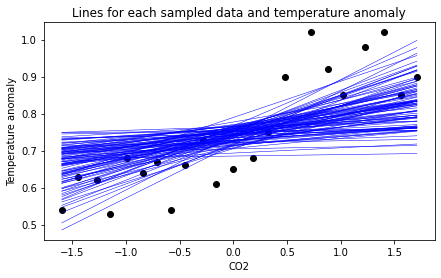

In [30]:
fig, axes = plt.subplots(1,1,figsize=(7,4))

beta_humid = fit7.stan_variable('beta_CO2')
alpha_humid = fit7.stan_variable('alpha')
for i in range(100):
    axes.plot(df['CO2'], alpha_humid[i]+beta_humid[i]*np.array(df['CO2']), linewidth = 0.5, color='b')
plt.title("Lines for each sampled data and temperature anomaly")
axes.scatter(df['CO2'], df['Temperature'], color= 'black')
axes.set_xlabel('CO2')
axes.set_ylabel('Temperature anomaly')
axes.annotate(text='max',xy=(80,320), weight = 'bold', color = 'r', fontsize = 15)
axes.annotate(text='min',xy=(80,20), weight = 'bold', color = 'r', fontsize = 15)

In this plot we can see lines adjusted to actual data. In the model we can see more spread at the end of the x-axis than in Gaussian model and model fits better.

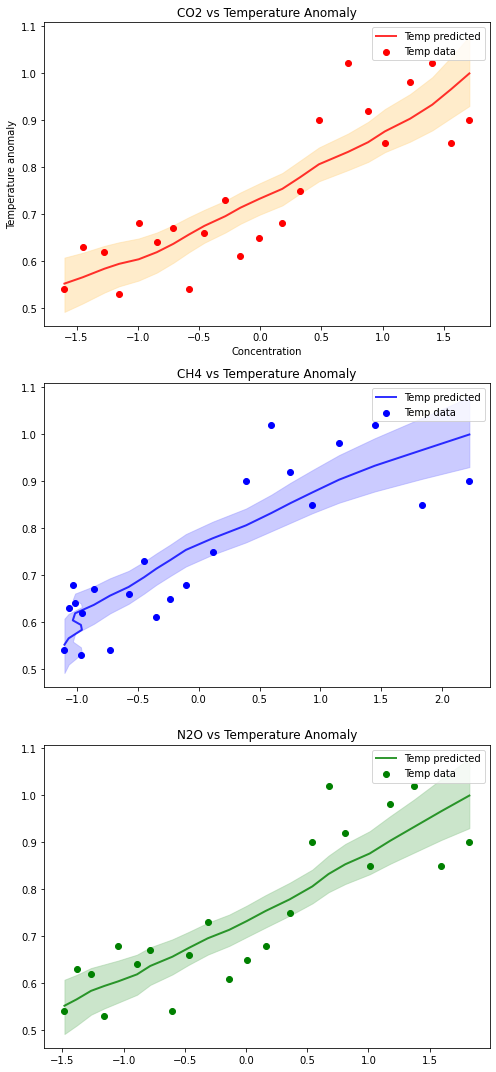

In [33]:
import matplotlib as mpl
CO2 = np.array(df['CO2'])
CH4 = np.array(df['CH4'])
N2O = np.array(df['N2O'])
Temperature = np.array(df['Temperature'])
mu_CO2 = fit7.stan_variable('mu')
mu_CH4 = fit7.stan_variable('mu')
mu_N2O = fit7.stan_variable('mu')


fig, ax = plt.subplots(3, 1, figsize=(7 ,15))

ax[0].fill_between(
    CO2,
    np.percentile(mu_CO2, 5, axis=0),
    np.percentile(mu_CO2, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('orange'))),
    alpha=0.5
)

ax[1].fill_between(
    CH4,
    np.percentile(mu_CH4, 5, axis=0),
    np.percentile(mu_CH4, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('blue'))),
    alpha=0.5
)

ax[2].fill_between(
    N2O,
    np.percentile(mu_N2O, 5, axis=0),
    np.percentile(mu_N2O, 95, axis=0),
    color=1 - 0.4 * (1 - np.array(mpl.colors.to_rgb('green'))),
    alpha=0.5
)

ax[0].plot(
    CO2,
    np.percentile(mu_CO2, 50, axis=0),
    color='red',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)
ax[1].plot(
    CH4,
    np.percentile(mu_CH4, 50, axis=0),
    color='blue',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)
ax[2].plot(
    N2O,
    np.percentile(mu_N2O, 50, axis=0),
    color='green',
    linewidth=2,
    alpha=0.8,
    label='Temp predicted'
)

ax[0].scatter(CO2, Temperature, color='red', label='Temp data')
ax[1].scatter(CH4, Temperature, color='blue', label='Temp data')
ax[2].scatter(N2O, Temperature, color='green', label='Temp data')

ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Temperature anomaly')


ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].set_title('CO2 vs Temperature Anomaly')
ax[1].set_title('CH4 vs Temperature Anomaly')
ax[2].set_title('N2O vs Temperature Anomaly')
plt.tight_layout()
plt.show()

In the output data we can see that provided data of temperatures anomaly fits great.

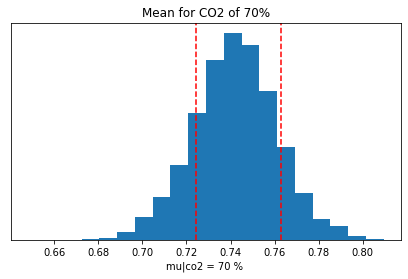

Mean: 0.74
70% confidence interval:  ['0.72', '0.76']


In [39]:
alpha_post =  fit7.stan_variable('alpha')
beta_post = fit7.stan_variable('beta_CO2')
mu_post = fit7.stan_variable('mu')

mu70 = alpha_post+beta_post*(np.mean(df['CO2']))
mu_70p = az.hdi(mu70,.70)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu70,bins=20,density=True)
plt.axvline(mu_70p[0], linestyle = '--', color = 'r')
plt.axvline(mu_70p[1], linestyle = '--', color = 'r')
ax.set_title('Mean for CO2 of 70%')
ax.set_yticks(())
ax.set_xlabel('mu|co2 = 70 % ')
plt.show()
print('Mean: {:4.2f}'.format(np.mean(mu70)))
print('70% confidence interval: ',['{:4.2f}'.format(k) for k in az.hdi(mu70,.70)])

Histogram shows that on 70% probability will be in range 0.72 and 0.76.

# Model comparison 

In [55]:
print("Summary - Normal model:")
fit.summary()

Summary - Normal model:


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,29.000,0.05200,1.800,25.0000,29.000,31.000,1200.0,2600.0,1.0
alpha,0.740,0.00041,0.020,0.7100,0.740,0.770,2400.0,5200.0,1.0
sigma,0.092,0.00024,0.012,0.0730,0.091,0.110,2600.0,5700.0,1.0
beta_CO2,0.049,0.00064,0.032,0.0046,0.045,0.110,2500.0,5500.0,1.0
beta_CH4,0.042,0.00054,0.030,0.0035,0.037,0.097,3000.0,6600.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[18],0.980,0.01100,0.710,-0.4700,1.200,1.600,3910.0,8613.0,1.0
log_lik[19],0.970,0.01100,0.690,-0.4500,1.200,1.600,3980.0,8766.0,1.0
log_lik[20],0.970,0.01200,0.740,-0.4800,1.200,1.600,3759.0,8279.0,1.0


In [56]:
print("Summary - Student model:")
fit7.summary()

Summary - Student model:


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,24.000,0.05500,2.000,21.0000,25.000,27.000,1300.0,1800.0,1.0
alpha,0.740,0.00038,0.019,0.7100,0.740,0.770,2600.0,3700.0,1.0
beta_CO2,0.049,0.00060,0.032,0.0053,0.046,0.110,2800.0,3900.0,1.0
beta_CH4,0.043,0.00053,0.030,0.0040,0.038,0.099,3200.0,4500.0,1.0
beta_N2O,0.043,0.00059,0.031,0.0040,0.037,0.100,2800.0,3900.0,1.0
...,...,...,...,...,...,...,...,...,...
log_lik[18],1.400,0.00380,0.200,1.1000,1.400,1.700,2688.0,3765.0,1.0
log_lik[19],1.000,0.00580,0.340,0.3900,1.100,1.500,3362.0,4708.0,1.0
log_lik[20],0.900,0.00700,0.410,0.1000,0.970,1.400,3511.0,4918.0,1.0


Values for returned parameters are quite similar. We assumed that in both models that may look alike

In [65]:
fitStudent_ = az.from_cmdstanpy(posterior=fit7,
                           log_likelihood='log_lik',
                           posterior_predictive='temp_i',
                           observed_data={'temperature':df['Temperature']})
fitStudent_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [61]:
fitNormal_ = az.from_cmdstanpy(posterior=fit,
                           log_likelihood='log_lik',
                           posterior_predictive='temp_',
                           observed_data={'temperature':df['Temperature']})

In [66]:
az.loo(fitStudent_)

Computed from 4000 by 22 log-likelihood matrix

         Estimate       SE
elpd_loo    20.87     2.62
p_loo        2.55        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       22  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [67]:
az.waic(fitStudent_)

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 22 log-likelihood matrix

          Estimate       SE
elpd_waic    20.92     2.60
p_waic        2.51        -

There has been a warning during the calculation. Please check the results.

The model with students distribution gives very similar result for WAIC and LOO

In [68]:
az.loo(fitNormal_)

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 22 log-likelihood matrix

         Estimate       SE
elpd_loo     6.01     0.73
p_loo       18.99        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1    4.5%
   (0.7, 1]   (bad)        16   72.7%
   (1, Inf)   (very bad)    5   22.7%

In [69]:
az.waic(fitStudent_)

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 22 log-likelihood matrix

          Estimate       SE
elpd_waic    20.92     2.60
p_waic        2.51        -

There has been a warning during the calculation. Please check the results.

In the model with Normal distribution only WAIC is the same as WAIC nad LOO for Student-t model. The reason why LOO and WAIC varies here it is because they have different evaluation strategies. WAIC focus on entire dataset while LOO on every point of data. When it comes to LOO it shows that model is not so good but focusing on whole dataset the evaluation is much better.

## LOO

In [71]:
LOO_compare = az.compare({'Student model':fitStudent_, 'Normal model':fitNormal_}, ic='loo')
LOO_compare

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Student model,0,20.873971,2.553913,0.000000,1.0,2.616999,0.000000,False,log
Normal model,1,6.009034,18.990402,14.864938,0.0,0.731370,2.418414,True,log


Smaller rank indicates which model is better. Here we can see that Student model is much better from the other one. But lets see the output when it comes to whole dataset -WAIC. 

<AxesSubplot:xlabel='Log'>

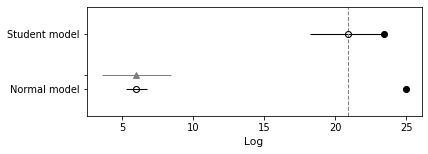

In [72]:
az.plot_compare(LOO_compare)

## WAIC

In [74]:
WAIC_compare = az.compare({'Student model':fitStudent_, 'Gaussian model':fitNormal_}, ic='waic')
WAIC_compare

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Student model,0,20.916747,2.511138,0.000000,1.0,2.602951,0.000000,True,log
Gaussian model,1,13.469474,11.529962,7.447273,0.0,0.163882,2.600035,True,log


Here also the output says that the Student model is better than the Gaussian Model. 

<AxesSubplot:xlabel='Log'>

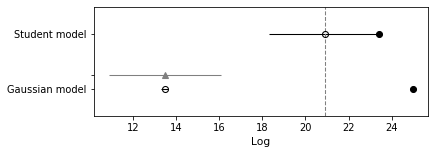

In [75]:
az.plot_compare(WAIC_compare)

With WAIC evaluation the difference is much smaller than with LOO but the better model is still the same. 

To sum up both models adjusted to the data pretty well. The secound approach turned out to be better than the first one - Gaussian. In the future we could add more parameters to the model or change the impact of the parameters to be different from each other. Also we could consider wider time range than just from 2001 to 2022. 